<center><img src='https://drive.google.com/uc?export=view&id=12CrUdXDAiltLBT26sG7HZ_HciIhvGyT8'></center>

# Statistical machine learning - Notebook 9, version for students
**Author: Michał Ciach**  


## Description


In today's class, we will analyze the properties of $k$-fold cross validation, the Bootstrap, and feature selection techniques.  


In [1]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1GW1pjKOCoKOlC4Jqbqql_ghYD_n0iC6O
!gdown https://drive.google.com/uc?id=1xOJfD-jexDbHSOCg1EiyAxqc5kXjMvX0

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.11/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

## Data & library imports

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import numpy.random as rd
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind, pearsonr, norm
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
protein_lengths = pd.read_csv('protein_lengths.tsv', sep='\t')
protein_lengths['LogLength'] = np.log10(protein_lengths['Protein length'])
protein_lengths

,Scientific name,Common name,Protein ID,Protein length,LogLength
0,Homo sapiens,Human,NP_000005.3,1474,3.168497
1,Homo sapiens,Human,NP_000006.2,290,2.462398
2,Homo sapiens,Human,NP_000007.1,421,2.624282
3,Homo sapiens,Human,NP_000008.1,412,2.614897
4,Homo sapiens,Human,NP_000009.1,655,2.816241
...,...,...,...,...,...
648731,Imleria badia,Bay bolete (mushroom),KAF8560453.1,494,2.693727
648732,Imleria badia,Bay bolete (mushroom),KAF8560454.1,737,2.867467
648733,Imleria badia,Bay bolete (mushroom),KAF8560455.1,554,2.743510
648734,Imleria badia,Bay bolete (mushroom),KAF8560456.1,813,2.910091


In [3]:
human_protein_lengths = protein_lengths.loc[protein_lengths['Common name'] == 'Human'].copy()
# Note: without .copy(), some versions of Pandas may return a View.
# This may interfere with adding a new column to human_protein_lengths.
human_protein_lengths.describe()

,Protein length,LogLength
count,136193.000000,136193.000000
mean,692.655775,2.711540
std,746.993628,0.329892
min,12.000000,1.079181
25%,316.000000,2.499687
50%,514.000000,2.710963
75%,842.000000,2.925312
max,35991.000000,4.556194


In [4]:
income = pd.read_csv('BDL municipality incomes 2015-2020.csv', sep=';', dtype={'Code': 'str'})
income = income.sort_values(by='2015')
income

,Code,Region,2015,2016,2017,2018,2019,2020
1040,1409012,Chotcza (2),1511535.39,1890875.56,1920288.34,1852794.08,2123747.76,2649856.24
508,0619042,Stary Brus (2),1564085.98,1572661.84,1765578.55,1723233.19,2076285.49,2309878.28
334,0602022,Aleksandrów (2),1579356.44,1662725.31,2388276.59,2342380.81,2408083.72,2626930.30
1110,1416092,Szulborze Wielkie (2),1583373.09,1634649.25,1535709.13,1751927.47,2029410.65,2693226.02
458,0613052,Podedwórze (2),1587356.04,1784064.91,1724407.04,1681474.34,1959836.88,2896485.76
...,...,...,...,...,...,...,...,...
2041,2612083,Szydłów (3),NaN,NaN,NaN,NaN,7753338.64,8139051.84
2157,2817083,Wielbark (3),NaN,NaN,NaN,NaN,13103456.39,19412519.56
2202,3006013,Jaraczewo (3),NaN,9296043.36,9682180.18,10663487.87,13167444.55,14740769.18
2214,3007083,Opatówek (3),NaN,NaN,18666712.20,21464319.39,26876091.60,30935048.42


In [5]:
voivodeship_names = {
    '02': 'Dolnośląskie',
    '04': 'Kujawsko-pomorskie',
    '06': 'Lubelskie',
    '08': 'Lubuskie',
    '10': 'Łódzkie',
    '12': 'Małopolskie',
    '14': 'Mazowieckie',
    '16': 'Opolskie',
    '18': 'Podkarpackie',
    '20': 'Podlaskie',
    '22': 'Pomorskie',
    '24': 'Śląskie',
    '26': 'Świętokrzyskie',
    '28': 'Warmińsko-mazurskie',
    '30': 'Wielkopolskie',
    '32': 'Zachodniopomorskie'
}
code_list = [s[:2] for s in income["Code"]]
name_list = [voivodeship_names[code] for code in code_list]
income['Voivodeship'] = name_list

In [6]:
is_a_city = [s[-1] == '1' for s in income['Code']]
city_income = income[is_a_city].dropna()
city_income = city_income[city_income.apply(lambda x: all(x!=0), axis=1)]  # removing zero incomes
city_income

,Code,Region,2015,2016,2017,2018,2019,2020,Voivodeship
172,0401031,Nieszawa (1),2.996709e+06,3.657721e+06,6.470331e+06,4.252369e+06,3.861400e+06,5.492712e+06,Kujawsko-pomorskie
2341,3024011,Obrzycko (1),3.924365e+06,3.925119e+06,4.665922e+06,5.146760e+06,6.234464e+06,6.191140e+06,Wielkopolskie
2255,3012011,Sulmierzyce (1),4.088118e+06,4.694543e+06,4.790061e+06,5.132589e+06,5.426530e+06,5.670122e+06,Wielkopolskie
436,0611021,Stoczek Łukowski (1),4.178149e+06,4.137683e+06,4.045226e+06,4.431016e+06,6.169249e+06,6.908153e+06,Lubelskie
1731,2213021,Skórcz (1),5.234237e+06,6.662443e+06,6.685645e+06,7.402352e+06,7.656451e+06,1.070215e+07,Pomorskie
...,...,...,...,...,...,...,...,...,...
2393,3064011,Poznań (1),2.004614e+09,2.127838e+09,2.298017e+09,2.451093e+09,2.656515e+09,2.664275e+09,Wielkopolskie
791,1061011,Łódź (1),2.386783e+09,2.473749e+09,2.536384e+09,2.627320e+09,2.829157e+09,2.895426e+09,Łódzkie
168,0264011,Wrocław (1),2.697637e+09,2.840414e+09,2.969824e+09,3.174794e+09,3.353249e+09,3.295384e+09,Dolnośląskie
974,1261011,Kraków (1),2.882882e+09,3.058201e+09,3.311715e+09,3.600811e+09,3.833362e+09,3.808958e+09,Małopolskie


## Estimating the test error of regression with cross-validation

Cross validation is a technique to estimate the test error of a prediction algorithm (either a classifier or a regression).  
The idea is to divide the training data set into $k$ parts and, for each part, use it as the test set and the rest as the training set.  
We will see how well this approach approximates a true test error and what happens for different values of $k$.  

To evaluate models, we typically partition our data set into three subsets: a *training set* on which we train our models, a *validation set* on which we test our models to select the best one, and a *test set* on which we do a final evaluation of our model and e.g. compare it to a baseline model. One of the approaches to do cross validation is to hold out a portion of the data set as the test set and to split the remaining data into a series of validation sets and training sets.

You should be aware that sometimes people reverse the meaning of the *validation* and the *test* sets. This is the case in the picture below, which is taken from Wikipedia - it depicts a series of test sets rather than validation sets. Although the terminology is inconsistent, the general idea stays the same, so if you have a good understanding of how cross validation works, you won't be confused.


<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/1920px-K-fold_cross_validation_EN.svg.png'>

*A diagram representing the k-fold cross validation.       
Source: https://commons.wikimedia.org/wiki/File:K-fold_cross_validation_EN.svg*
</center>


**Exercise 1.** In this exercise, we will build a simple linear regression model to predict the income of cities in Poland in the year 2017 based on the incomes in 2015 and 2016, and we will check how well the k-fold cross validation approximates its test error. We will use the data in the `city_income` data frame generated in the *Data & modules* section. Let $R$ be the number of rows in this data frame.   

1. Perform a log-transformation of the incomes.  
2. Permute the rows of the data frame randomly in order to eliminate any grouping of the data that could bias the estimation of the errors. You can use the `city_income.sample(frac=1)` command.  
3. Create a data frame with the first $T=50$ observations. This will be our *test set*, where our model will need to predict the incomes. The RMSE of prediction on this set is called the *test error*.  
4. Create a data frame with the remaining $R-T$ observations. This will be our *full training set*, where our model will learn how to make predictions. The RMSE of prediction on this set is called the *training error.*  
5. Using the full training data set, create a linear regression model to predict the log-incomes in 2017 based on the log-incomes in 2015 and 2016.
Predict the log-incomes in 2017 for the test set and calculate the true value of the test error.  
6. Now, we will try to use k-fold cross validation to predict the test error using only the training data set (i.e. without looking at the test set at all). Create a list with several values of the $k$ parameter, including 5, 10 (the two most commonly used values), 15, 60, and the size of the full training set (for a so-called *leave-one-out* cross validation).  
7. For each value of $k$, perform a $k$-fold cross-validation. For $i=1,\dots, k$:  
  7.1. Select observations $(i-1)\lfloor (R-T)/k \rfloor$ up to $i\lfloor (R-T)/k \rfloor$ from the full training data set and save them as the *validation set*. Save the remaining observations as a *partial training set*.  
  7.2. Create a linear regression model on the partial training set. Calculate its predictions for the validation set. Calculate the validation error (RMSE) and store it in a list.  
8. For each $k$, calculate the mean and standard deviation of the corresponding validation errors.   
  8.1. Can you see some trends in those values? Can you explain it?
  8.2. Which $k$ best approximates the true test error?
9. Plot the distributions of errors on histograms.   
  9.1. Which $k$ gives you the most information about the distribution of the test error?     
10. Check what would happen if we didn't do the log-transformation in step 1. Can you explain the results?  
  10.1.\* To give a more detailed answer, do an exploratory analysis and figure out the distribution of the incomes.   
11. Check what would happen if we didn't do the permutation in step 2. Can you explain the results?
12. Let's suppose we don't know the incomes of the cities for the year 2018. Can we use our model to predict them? Can we estimate the prediction error using k-fold cross validation? Why/why not?    
13. In point 7, we have iterated over $i=1,\dots, k$. Do you see a potential problem or inefficiency when $k$ doesn't divide $R-T$? Does it make sense to iterate over $i=1,\dots, k+1$? What are the possible advantages and disadvantages?   

In [9]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

city_income[["2015", "2016", "2017"]] = city_income[["2015", "2016", "2017"]].apply(lambda x: np.log(x))

city_income = city_income.sample(frac=1)

test_set = city_income.iloc[:50]

train_set = city_income.iloc[50:]

X_train = train_set[["2015", "2016"]]
y_train = train_set["2017"]
model = LinearRegression().fit(X_train, y_train)

In [10]:
X_test = test_set[["2015", "2016"]]
y_test = test_set["2017"]
y_pred = model.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)

k_values = [5, 10, 15, 60, len(train_set)]
for k in k_values:
    kf = KFold(n_splits=k)
    errors = []
    errors_train = []
    for train_index, val_index in kf.split(train_set):
        X_train_k, X_val_k = train_set.iloc[train_index][["2015", "2016"]], train_set.iloc[val_index][["2015", "2016"]]
        y_train_k, y_val_k = train_set.iloc[train_index]["2017"], train_set.iloc[val_index]["2017"]
        model_k = LinearRegression().fit(X_train_k, y_train_k)
        y_pred_k = model_k.predict(X_val_k)
        errors.append(np.sqrt(mean_squared_error(y_val_k, y_pred_k)))
        Y_train_pred = model_k.predict(X_train_k)
        errors_train.append(np.sqrt(mean_squared_error(y_train_k, Y_train_pred)))
    print(f"Test error for k={k}: {sum(errors)/len(errors)}")
    print(f"Train error for k={k}: {sum(errors_train)/len(errors_train)}")


Test error for k=5: 0.07546002718233172
Train error for k=5: 0.074473557358538
Test error for k=10: 0.07357578185909631
Train error for k=10: 0.07463944349135318
Test error for k=15: 0.07126945408450105
Train error for k=15: 0.07467424153155987
Test error for k=60: 0.06409409091345158
Train error for k=60: 0.07477095947588579
Test error for k=251: 0.050622306050507423
Train error for k=251: 0.07479391702216164


**Exercise 2.** Let's make a better model! We can reasonably assume that the average income is different in each voivodeship, rather than common for the whole country. Next, we can assume a more complex relation between the incomes - for example, the income in a given year may depend on the previous incomes, but also on the squares of the previous incomes, and the products of the previous incomes. This corresponds to a model with an interaction - a high income in both 2015 and 2016 is a better indicator of a high income in 2017 than a high income in just a single year. This is a reasonable assumption, because consistently stable incomes indicate a stable economy, while a high income in just a single year can be caused by random events. Both assumptions can improve our model by making it fit the data better. What could possibly go wrong?  

1. Write down the mathematical equation for the model described above. Are you going to use a model with an intercept?   
2. Create a data frame `X` with the independent variables: the city incomes in 2015 and 2016, their second powers, their product, and voivodeships encoded as dummy variables. Use the `pd.get_dummies` variables to encode the voivodeships. Create a data frame `Y` with the independent variable (the incomes in 2017).  
3. Withhold $T=50$ observations from `X` and `Y` as the *test* data set, and remove these observations from `X` and `Y`.  
4. Create a linear regression model on the *training* data set. Calculate its train and test RMSE. Compare the errors with the model from Exercise 1.  
  4.1. Did the train RMSE decrease? Why?  
  4.2. Did the test RMSE decrease as well? Why?  
  4.3. Is the test RMSE considerably higher than the train RMSE? Is the difference between those errors larger than in exercise 1?  


In [11]:
import pandas as pd
import numpy as np


#city_income = city_income.sample(frac=1)

X = pd.DataFrame()
X['X_2015'] = city_income['2015']
X['X_2016'] = city_income['2016']
X['X_2015^2'] = city_income['2015'] ** 2
X['X_2016^2'] = city_income['2016'] ** 2
X['X_2015*X_2016'] = city_income['2015'] * city_income['2016']
X = pd.concat([X, pd.get_dummies(city_income['Voivodeship'])], axis=1)

In [12]:
Y = city_income['2017']

In [13]:
T = 50

X_train = X[:-T]
X_test = X[-T:]
Y_train = Y[:-T]
Y_test = Y[-T:]

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)


train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 0.07
Test RMSE: 0.11


**Exercise 3.** Even if a model is reasonable, it may perform poorly if it's too flexible and overfits to the data. In the previous exercise, you may, or may not have, concluded that the new model overfits. However, any result obtained that way is not very robust - after all, we have checked the performance only on a single selected test set. Maybe the result was just a random artifact caused by an unfortunate permutation of the rows of `city_income`? That's where cross-validation again comes in handy.    


1. Create a data frame `X` containing the independent variables (predictors) like in Exercise 2. Don't withhold the test set this time - we won't need it anymore.  
2. Select your favorite value of $k$ for a k-fold cross validation.  
3. Use the `cross_val_score` function from the `sklearn` library to evaluate the complex model from Exercise 2 and the simple model from Exercise 1. To evaluate a model with RMSE, use a keyword argument `scoring='neg_root_mean_squared_error'`.   
  3.1. Compare the average test errors of the two models. Can you conclude that the complex model overfits?  
  3.2. Check the standard deviation of the errors. Is it much lower than the average of the errors? Is the conclusion about overfitting robust, or could it occur just by chance?      
  3.3. \* Can you come up with some statistical method to decide whether the test RMSE of the complex model really is higher than the RMSE of the simple model, rather than being caused just by random chance?
4. \* Implement a k-fold cross validation and, in each iteration, save *both* the training and the test RMSE of the fitted model (or figure out how to get the train RMSE with `sklearn`).   
  4.1 Calculate the mean and standard deviation of the four errors. Analyze the difference between the test MSE and the train MSE of the two models. Does this provide some additional useful information compared to just the test MSE?  
5. Can the conclusion about overfitting depend on the value of $k$? Why/why not?  


In [15]:
k = 10

In [16]:
import pandas as pd
import numpy as np

X = pd.DataFrame()
X['2015'] = city_income['2015']
X['2016'] = city_income['2016']
X['2015^2'] = city_income['2015'] ** 2
X['2016^2'] = city_income['2016'] ** 2
X['2015*2016'] = city_income['2015'] * city_income['2016']
X = pd.concat([X, pd.get_dummies(city_income['Voivodeship'])], axis=1)

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


y = city_income["2017"]

model1 = LinearRegression().fit(X, y)

scores1 = -cross_val_score(model1, X, y, cv=k, scoring="neg_root_mean_squared_error")
print(f"Average test error for the model 1: {np.mean(scores1)}")
print(f"Standard deviation of the test errors for the model 1: {np.std(scores1)}")

model2 = LinearRegression().fit(X[["2015", "2016"]], y)

scores2 = -cross_val_score(model2, X[["2015", "2016"]], y, cv=k, scoring="neg_root_mean_squared_error")
print(f"Average test error for the model 2: {np.mean(scores2)}")
print(f"Standard deviation of the test errors for the model 2: {np.std(scores2)}")

Average test error for the model 1: 0.0778398585237707
Standard deviation of the test errors for the model 1: 0.02103187794847424
Average test error for the model 2: 0.07695327148774601
Standard deviation of the test errors for the model 2: 0.021989585324403375


In [26]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def do_LR(X_train, X_test, y_train, y_test):
    model1_cross = LinearRegression().fit(X_train, y_train)
    y_train_pred1 = model1_cross.predict(X_train)
    y_test_pred1 = model1_cross.predict(X_test)

    train_rmse1 = rmse(y_train, y_train_pred1)
    test_rmse1 = rmse(y_test, y_test_pred1)
    return train_rmse1, test_rmse1

train_errors1 = []
test_errors1 = []
train_errors2 = []
test_errors2 = []


kf = KFold(n_splits=300)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_rmse1, test_rmse1 = do_LR(X_train, X_test, y_train, y_test)

    
    X_train, X_test = X.iloc[train_index][["2015", "2016"]], X.iloc[test_index][["2015", "2016"]]
    
    train_rmse2, test_rmse2 = do_LR(X_train, X_test, y_train, y_test)
    
    train_errors1.append(train_rmse1)
    test_errors1.append(test_rmse1)
    
    train_errors2.append(train_rmse2)
    test_errors2.append(test_rmse2)

print(f"Mean Train RMSE 1: {np.mean(train_errors1)}")
print(f"Mean Test RMSE 1: {np.mean(test_errors1)}")
print(f"Standard Deviation of train RMSE 1: {np.std(train_errors1)}")
print(f"Standard Deviation of Test RMSE 1: {np.std(test_errors1)}")

print(f"Mean Train RMSE 2: {np.mean(train_errors2)}")
print(f"Mean Test RMSE 2: {np.mean(test_errors2)}")
print(f"Standard Deviation of train RMSE 2: {np.std(train_errors2)}")
print(f"Standard Deviation of Test RMSE 2: {np.std(test_errors2)}")

Mean Train RMSE 1: 0.07265422426298276
Mean Test RMSE 1: 0.05299344191395331
Standard Deviation of train RMSE 1: 0.0005419213427168018
Standard Deviation of Test RMSE 1: 0.06002901714545975
Mean Train RMSE 2: 0.07834784912289537
Mean Test RMSE 2: 0.051426546095853516
Standard Deviation of train RMSE 2: 0.0005353992703766085
Standard Deviation of Test RMSE 2: 0.06162237905856489


In [27]:
print(f"test - train MSE for the model 1: {np.mean(train_errors1) - np.mean(test_errors1)}")
print(f"test - train MSE for the model 2: {np.mean(train_errors2) - np.mean(test_errors2)}")

test - train MSE for the model 1: 0.019660782349029453
test - train MSE for the model 2: 0.026921303027041855


## Analyzing estimators with the Bootstrap

The Bootstrap is a non-parametric technique used to quantify the uncertainty of estimation and to perform hypothesis testing.   
As you may remember, *non-parametric* means that you don't need to know the probability distribution of your data to use this technique.  
Therefore, Bootstrap allows you to test hypotheses for any data sets, not just normally distributed ones. However, it has the same downsides as all the other non-parametric techniques.  
In particular, it's difficult to analyze theoretically, so we can't really say how well it performs by analyzing it like in the case of the Student's t-test.  

The idea behind bootstrap is as follows. Suppose we have a statistical sample of size $n$, $X_1, \dots, X_n$, and some statistic (e.g. the mean or the variance) that we compute from this sample, denoted $f(X_1, \dots, X_n)$, to estimate some parameter.  
Suppose we want to quantify the uncertainty of this estimation, but don't know how to calculate the variance of $f(X_1, \dots, X_n)$ analytically.  
In this case, we can sample $n$ observations **with replacement** from $X_1, \dots, X_n$ to get a new sample $X_1^*, \dots, X_n^*$, calculate $f(X_1^*, \dots, X_n^*)$, and repeat this procedure multiple times to get a sample of values of the statistic $f$.  
It turns out that the distribution of $f$ obtained this way mimics its true distribution.   

It's important to remember that to get a proper result, we need to get a  sample of the same size (otherwise, we change the parameters of our statistic - e.g. a mean computed from a smaller sample will have a higher variance), and to sample with replacement (otherwise, if we sample without replacement, we just get a permutation of the values).

**Exercise 4.** In this exercise, we will use the bootstrap technique to analyze the properties of the estimator of the standard deviation of a protein log-length. We will use this to decide which type of a confidence interval for the mean we can use.  

Just to remind you, there are three common types of a confidence interval for the mean of a normally distributed population. The first type is for a known $\sigma$ and is given by
$$\left (\hat{\mu} - q_{(1+\alpha)/2}\frac{\sigma}{\sqrt{N}},\quad \hat{\mu} + q_{(1+\alpha)/2}\frac{\sigma}{\sqrt{N}} \right ), $$
and the second type, for an unknown $\sigma$, is given by
$$\left (\hat{\mu} - t_{(1+\alpha)/2, N-1}\frac{\hat{\sigma}}{\sqrt{N}},\quad \hat{\mu} + t_{(1+\alpha)/2, N-1}\frac{\hat{\sigma}}{\sqrt{N}} \right )$$
The third type, called an *asymptotic* confidence interval, is given by the same formula as the first one, but with estimated standard deviation (i.e. put $\hat{\sigma}$ instead of $\sigma$ in the equation). If we can estimate $\sigma$ *very precisely*, we may choose to use this third type to obtain a more precise result (i.e. a shorter interval).   

1. Select $N=50$ random samples from the `human_protein_lengths` data and put them into a new data frame called e.g. `sample`. Calculate the standard deviation of the sampled protein log-lengths.  
2. Now, we will use the bootstrap to estimate the distribution of the estimator. Repeat the following $R=10 000$ times:  
  2.1. Resample the observations from the `sample` data frame, e.g. using the `sample.sample()` method.  
  2.2. Calculate the standard deviation from the resampled observations and store it in a list.   
3. Plot the obtained bootstrap replicates of the standard deviation on a histogram. Calculate the mean and standard deviation of the estimator, and check its coefficient of variation.
  3.1. In your opinion, is the standard deviation estimated sufficiently precisely to use the asymptotic confidence interval?  
  3.2. How does the error in the estimation of the standard deviation influence the length of the asymptotic confidence interval?   
  3.3. Create a histogram showing bootstrapped lengths of the asymptotic confidence interval. To calculate the lengths, you can use the bootstraped replicates of the standard deviation.   
  3.4. Do the answers to the previous points depend on $N$?  
4. Estimate the true distribution of the estimator of the standard deviation. To do this, draw $R$ samples of size $N$ of the log-lengths of human proteins and calculate the standard deviation for each sample.  
  4.1. Plot the obtained $R$ values of the estimator on a histogram and compare it to the histogram of bootstrapped replicates. Are the distributions similar?  
  4.2. Use the $R$ values to estimate the expected value and standard deviation of the estimator. Compare it to the values obtained with the bootstrap. Are the bootstrap estimates similar to the true parameters of this estimator?  


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
N = 50
sample = human_protein_lengths.sample(n=N)

In [8]:
sample_log_lengths = np.log(sample['LogLength'])
sample_std = np.std(sample_log_lengths)

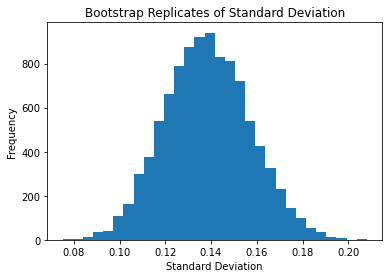

In [9]:
R = 10000
bootstrap_std = []
for i in range(R):
    resampled = sample_log_lengths.sample(n=N, replace=True)
    bootstrap_std.append(np.std(resampled))

plt.hist(bootstrap_std, bins=30)
plt.title('Bootstrap Replicates of Standard Deviation')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.show()

In [10]:
bootstrap_mean = np.mean(bootstrap_std)
bootstrap_std = np.std(bootstrap_std)
cv = bootstrap_std / bootstrap_mean
print(f"Mean: {bootstrap_mean:.2f}, Standard Deviation: {bootstrap_std:.2f}, Coefficient of Variation: {cv:.2f}")
# a good estimate of the true standard deviation of the population. Therefore, it can be used to calculate the asymptotic confidence interval.

Mean: 0.14, Standard Deviation: 0.02, Coefficient of Variation: 0.13


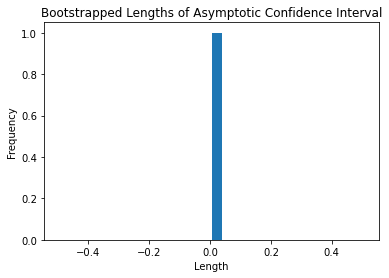

In [11]:
# The error in the estimation of the std will affect the length of the asymptotic confidence interval. A larger error will result in a wider confidence interval.

asymptotic_ci_lengths = 1.96 * bootstrap_std / np.sqrt(N)
plt.hist(asymptotic_ci_lengths, bins=30)
plt.title('Bootstrapped Lengths of Asymptotic Confidence Interval')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# the answers to the previous points depend on N. As N increases, the standard deviation estimated from the bootstrap method becomes more accurate, and the asymptotic confidence interval becomes narrower.

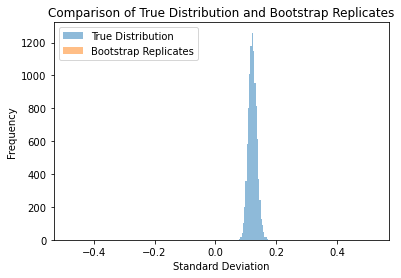

In [13]:
R = 10000
true_std = []
for i in range(R):
    sample = human_protein_lengths.sample(n=N)
    true_std.append(np.std(np.log(sample['LogLength'])))

plt.hist(true_std, bins=30, alpha=0.5, label='True Distribution')
plt.hist(bootstrap_std, bins=30, alpha=0.5, label='Bootstrap Replicates')
plt.title('Comparison of True Distribution and Bootstrap Replicates')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Use the R values to estimate the expected value and standard deviation of the estimator.
true_mean = np.mean(true_std)
true_std = np.std(true_std)
print(f"True Mean: {true_mean:.2f}, True Standard Deviation: {true_std:.2f}")

**Exercise 5.** In this exercise, we will use the bootstrap to estimate the bias of the estimator of standard deviation. It works like this. Let $X = X_1, \dots, X_N$ be a random sample from a population, and let $\hat\sigma(X)$ be the estimator of the standard deviation $\hat\sigma(X) = \sqrt{\sum (X_i - \bar X)^2 / N}$. Let $X^*_1, \dots, X^*_B$ be the bootstrap replicates from $X$, where $X^*_1 = X^*_{1,1}, \dots, X^*_{1, N}$. To estimate the bias of $\hat\sigma$, we simply calculate

$$\frac{1}{B}\sum_{i=1}^B (\hat\sigma(X^*_i) - \hat\sigma(X)).$$

*Warning.* This procedure works for a broad class of estimators (like the common estimators of the standard deviation or the variance), but not for all of them. You should be careful if you want to use it in your own analyses. You can read more in the book *An Introduction to the Bootstrap* by Efron and Tibshirani.  

1. Estimate the bias of $\hat\sigma$ using the bootstrap replicates from the previous Exercise. Does the result suggest that the estimator is biased or unbiased? Is this a correct result?
2. What if you use $N-1$ instead of $N$ in the denominator of the estimator, i.e. use an estimator based on the unbiased estimator of the variance?  
3. Verify your results by estimating the bias of $\hat\sigma$ using random samples of proteins and the true value of the standard deviation of the log-length.  
4. \* Can you give a short argument on why this estimation of the bias works?  
5. How does the bias of the estimator influence the length of the asymptotic confidence intervals - on average, are they too short, too long, or neither? What is the consequence for the actual confidence level of this type of interval?


In [ ]:
bias_bootstrap = bootstrap_std - true_std
print(f"Bias Estimated from Bootstrap Replicates: {bias_bootstrap}")

In [ ]:
std_unbiased_denominator = np.std(bootstrap_std, ddof=1)
print(f"Standard Deviation with Unbiased Denominator: {std_unbiased_denominator}")

# Calculate the bias using the unbiased denominator
bias_unbiased_denominator = std_unbiased_denominator - true_std
print(f"Bias with Unbiased Denominator: {bias_unbiased_denominator}")

In [ ]:
def draw_samples_and_calculate_std(R, N):
    std_values = []
    for _ in range(R):
        sample = human_protein_lengths['LogLength'].sample(N, replace=True)
        std_values.append(np.std(sample, ddof=1))
    return std_values

std_values_unbiased_denominator = draw_samples_and_calculate_std(10000, N)

# Calculate the bias using random samples and unbiased denominator
bias_true_value_unbiased_denominator = np.mean(std_values_unbiased_denominator) - std_true_distribution
print(f"Bias Estimated from True Distribution with Unbiased Denominator: {bias_true_value_unbiased_denominator}")


**Exercise 6.\*\*** One of the applications of estimating a distribution is performing hypothesis testing when it's difficult or impossible to calculate the distribution of a test statistic analytically. Recall that hypothesis testing proceeds as follows:  
1. We set a null hypothesis $H_0$, and alternative hypothesis $H_1$, and a test statistic $T$ that will give the test a high statistical power.  
2. We derive the distribution of $T$ assuming $H_0$ is true.  
3. We calculate the observed value of the test statistic, $T^*$.  
4. We define the critical region $C_{T^*}$ such that $T \in C_{T^*}$ is unlikely under $H_0$, but more likely under $H_1$. Often, $C = \{t \in \mathbb{R}: t \leq -|T^*| \text{ or } t \geq |T^*|\}$. The critical region is selected to get as high power of the test as possible.
4. We calculate the p-value $p = \mathbb{P}(T \in C_{T^*} | H_0)$, i.e. the probability that $T$ falls into the critical region $C_{T^*}$ assuming $H_0$ is true. Low p-values indicate that $H_0$ is false. The *significance level* of the test is the threshold of the p-value below which we discard $H_0$.     

We can use the bootstrap to complete step 2 when we don't know the distribution of the test statistic. To do this, we obtain bootstrap replicates of our statistical sample and calculate the value of $T$ in each replicate.  
However, when we estimate the distribution of $T$, we need to ensure that $H_0$ is true. To do this, we usually need to transform our sample. We'll see how to do this on an example of testing the equality of mean log-lengths of proteins in two organisms.  

1. Write a function that takes two vectors and returns the value of the test statistic $T$ of the [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test).  
2. Select two random samples, each of size $N=20$, of protein log-lengths from two organisms.  
3. Compute the observed value of the Welsch's test statistic, $T^*$, for these two samples.   
4. Now, we will use the bootstrap to obtain the distribution of $T$ under the null hypothesis that the mean log-lengths are equal. Note that, in the following substeps, we equalize the means in the *samples*, not in the *populations* - we pretend that we don't have any other data than the two samples of size $N$, and that we don't know the true means. Therefore, the null hypothesis will be valid only asymptotically (i.e. for infinite sample sizes).
  4.1. Calculate the mean log-lengths of proteins in both samples.  
  4.2. Subtract the corresponding mean from each sample, so that both vectors of log-lengths have a zero mean.  
  4.3. For 1000 times or more, resample the log-lengths from both vectors and compute the value of the test statistic $T$.  
  4.4. Visualize the distribution of $T$ under the null hypothesis on a histogram.   
5. Calculate the p-value by checking the proportion of bootstrapped values of $T$ that are at least as extreme as $T^*$ (for an alternative hypothesis of your choice). Do you reject the null hypothesis?
6. Perform a Welch's t-test using the `scipy.ttest_ind` function and compare the results. Are the p-values similar?  
  6.1. Note that you may use the output of this function to verify if you have computed $T^*$ properly.

## Model selection

**Exercise 7.**  In Exercises 2 and 3 we've seen that seemingly reasonable models may perform worse if they have too many variables. This is because a high flexibility allows them to learn spurious signals in the training data set that do not generalize to new observations and decrease their performance. However, some of the additional variables may indeed be useful. How, then, do we pick the best set of features for our model?  

In principle, we could inspect all the possible combinations of features. However, this is often prohibitively expensive computationally. Typically, we use one of the following heuristic approaches:  
1. The *forward* model selection, where we start with an empty model and iteratively add one feature that gives the best improvement
2. The *backwards* model selection, where we start with a full model (i.e. with all the features that we can take) and we iteratively remove one feature; we select the feature such that its removal gives the best improvement
3. The *forward-backward* model selection, where we start with an empty model and iteratively either add or remove one feature, depending on which gives the best improvement  
4. The *backward-forward* model selection, which you can figure out at this point.  

All the procedures iterate either until we reach a desired number of variables, or until we can no longer improve our model. There are several methods to evaluate the improvement of our model that we get by adding or removing a feature. The most general one is the test error estimated with k-fold cross validation. In this exercise, we will use this technique to select the best model to predict city incomes in 2018.   

1. Create a data frame `X` of the independent variables: incomes in 2015, 2016 and 2017, their second powers, and their products. Add an intercept, i.e. a constant column equal 1.   
2. Create a `LinearRegression` object with `fit_intercept=False`. In this exercise we add the intercept manually, because we want to include it in the model selection procedure.  
3. Use the `SequentialFeatureSelector` function from scipy to perform a forward model selection until adding a feature does not improve the model, with test error estimated using 10-fold cross validation. Look up the documentation of this function online in order to correctly specify the keyword arguments `n_features_to_select`, `cv` and `tol`.  
  3.1. Inspect the new model. Estimate its test error with cross validation with the same $k$ as you used in Exercise 2 and 3. Did you get a better test error? If yes, does it mean that you have found the best set of features?       
  3.2. Experiment with different values of the `tol` parameter. Did increasing or decreasing it allow you to find a better model? Why?  
4. Now, perform a backwards model selection using `SequentialFeatureSelector`.  
  4.1. Did you obtain the same model as in point 3? If not, which model is better?  
  4.2. What are the possible advantages and disadvantages of the backward strategy compared to the forward strategy?   
  4.3. Experiment with different values of the `tol` parameter. Did increasing or decreasing it allow you to find a better model? Why?  
5. \** Implement your own forward-backward procedure. Iterate until the difference between the new and the current model RMSE is not larger than 0.01 (i.e. we modify our model even if we get a slightly worse RMSE). We set this threshold in order to search more models - a temporary decrease in model performance may allow us to discover a better model.  
  5.1. What risks do we run into when we can both increase and decrease model performance in consecutive steps? How to handle it?  
  5.2. Use your implementation to select the best set of features for predicting city incomes. Was removing a feature beneficial at any step?  
  5.3. Did you obtain a better performance than using a simple forward strategy?  
  5.4. Did the error threshold of 0.01 allow you to find a better model compared to an error threshold equal zero (i.e. accepting a new model only if it improves over the current one)?  

In [ ]:
import pandas as pd
import numpy as np

X = pd.DataFrame()
X['2015'] = city_income['2015']
X['2016'] = city_income['2016']
X['2017'] = city_income['2017']
X['2015^2'] = city_income['2015'] ** 2
X['2016^2'] = city_income['2016'] ** 2
X['2017^2'] = city_income['2017'] ** 2
X['2015*2016'] = city_income['2015'] * city_income['2016']
X['2015*2017'] = city_income['2015'] * city_income['2017']
X['2017*2016'] = city_income['2017'] * city_income['2016']
X['constant'] = 1  # intercept

y = city_income["2018"]

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score

sfs_forward = SequentialFeatureSelector(model, n_features_to_select=None, direction='forward', cv=10, tol=0.01)
sfs_forward.fit(X, y)
selected_feature_indices = sfs_forward.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]
print("Selected features from forward model selection:", selected_features)

In [ ]:
X_forward_selected = X[selected_features]
cross_val_error_forward = np.mean(-cross_val_score(model, X_forward_selected, y, scoring='neg_mean_squared_error', cv=10))

print(f"Test error for forward model selection: {cross_val_error_forward}")

In [ ]:
sfs_backward = SequentialFeatureSelector(model, n_features_to_select=None, direction='backward', cv=10, tol=0.01)
sfs_backward.fit(X, y)
selected_feature_indices_backward = sfs_backward.get_support(indices=True)
selected_features_backward = X.columns[selected_feature_indices_backward]

print("Selected features from backward model selection:", selected_features_backward)

Advantages:

- It starts with a full model, potentially considering interactions between variables.
- It may be more conservative in removing features that don't add much predictive power.
Disadvantages:

- It can be computationally expensive for a large number of features.
- It may remove useful features early if they don't show a strong individual effect.

**Exercise 8.** The city council of Bajtowo has lost the income data for 2017. Their income data base reads as follows:

2015: 23 070 510.29 PLN  
2016: 24 454 660.81 PLN  
2017: ???  
2018: 27 085 401.60 PLN  
2019: 31 890 616.12 PLN    
2020: 33 421 082.55 PLN    

The mayor of Bajtowo has asked for your help. Create a model to predict the missing income and estimate its prediction error.    

<center><img src='https://drive.google.com/uc?export=view&id=12CrUdXDAiltLBT26sG7HZ_HciIhvGyT8'></center>